In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv
/kaggle/input/costa-rican-household-poverty-prediction/codebook.csv
/kaggle/input/costa-rican-household-poverty-prediction/train.csv.zip
/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv.zip
/kaggle/input/costa-rican-household-poverty-prediction/codebook.xlsx
/kaggle/input/costa-rican-household-poverty-prediction/train.csv
/kaggle/input/costa-rican-household-poverty-prediction/test.csv
/kaggle/input/costa-rican-household-poverty-prediction/test.csv.zip


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [56]:
train = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/train.csv')
test = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/test.csv')

In [57]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

accuracy: 0.9729819879919946
cohen_kappa_score: 0.9639759839893263
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98      1499
         2.0       0.97      0.95      0.96      1499
         3.0       0.97      0.97      0.97      1499
         4.0       0.98      0.98      0.98      1499

    accuracy                           0.97      5996
   macro avg       0.97      0.97      0.97      5996
weighted avg       0.97      0.97      0.97      5996



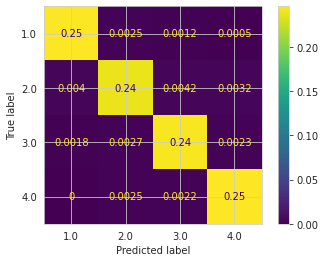

In [58]:
from sklearn.preprocessing import LabelEncoder

data = pd.concat([train, test])

for i in data.select_dtypes('object').columns:
  lencoders=LabelEncoder()
  data[i] = lencoders.fit_transform(data[i])
    
    
data = data.drop(['rez_esc', 'v18q1', 'v2a1'], axis=1)

data['SQBmeaned'] = data['SQBmeaned'].fillna(data['SQBmeaned'].median())
data['meaneduc'] = data['meaneduc'].fillna(data['meaneduc'].median())

train = data[data.Target.notnull()]
test = data[data.Target.isnull()]
test = test.drop(['Target'], axis=1)

X = train.drop(['Target'], axis=1)
Y = train['Target']

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=100, n_jobs=-1)
X_resampled, Y_resampled = smote.fit_resample(X,Y)

train_x = pd.DataFrame(X_resampled, columns=X.columns)
train_y = pd.Series(Y_resampled, name='Target')

train = pd.concat([train_x, train_y], axis=1)

x = train.drop(['Target'], axis=1)
y = train['Target']


from sklearn.preprocessing import robust_scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, log_loss
from keras.utils import to_categorical
import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import SVC


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.25, random_state=1234, stratify=y)

model_lgbm = lgbm.LGBMClassifier(n_estimators=500)
model_lgbm.fit(x_train, y_train)
y_pred_lgbm = model_lgbm.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_lgbm))
print('cohen_kappa_score:', cohen_kappa_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
plot_confusion_matrix(model_lgbm, x_test, y_test, normalize='all')

[06:08:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9721480987324883
cohen_kappa_score: 0.9628641316433177
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98      1499
         2.0       0.97      0.95      0.96      1499
         3.0       0.97      0.98      0.97      1499
         4.0       0.98      0.98      0.98      1499

    accuracy                           0.97      5996
   macro avg       0.97      0.97      0.97      5996
weighted avg       0.97      0.97      0.97      5996



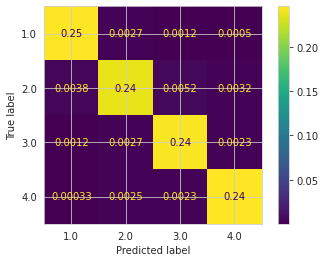

In [53]:
model_xgb = xgb.XGBClassifier(n_jobs=-1, n_estimators=500)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_xgb))
print('cohen_kappa_score:', cohen_kappa_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(model_xgb, x_test, y_test, normalize='all')

accuracy: 0.951967978652435
cohen_kappa_score: 0.9359573048699132
              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96      1499
         2.0       0.96      0.91      0.93      1499
         3.0       0.95      0.95      0.95      1499
         4.0       0.95      0.99      0.97      1499

    accuracy                           0.95      5996
   macro avg       0.95      0.95      0.95      5996
weighted avg       0.95      0.95      0.95      5996



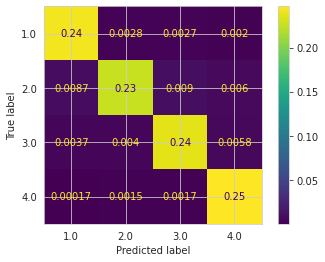

In [42]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_rf))
print('cohen_kappa_score:', cohen_kappa_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(model_rf, x_test, y_test, normalize='all')

In [ ]:
print(grid_rf.best_params_)

In [61]:
from sklearn.model_selection import StratifiedKFold

kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
for train_index, test_index in kf.split(x_train, y_train):
    print("###")
    X_train, X_val = x_train.iloc[train_index], x_train.iloc[test_index]
    Y_train, Y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    model_lgbm.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], 
            early_stopping_rounds=400, verbose=100)
    predicts_result.append(model_lgbm.predict(test))

###
Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_logloss: 0.358044
[200]	valid_0's multi_logloss: 0.219693
[300]	valid_0's multi_logloss: 0.163099
[400]	valid_0's multi_logloss: 0.134218
[500]	valid_0's multi_logloss: 0.122381
Did not meet early stopping. Best iteration is:
[499]	valid_0's multi_logloss: 0.122361
###
Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_logloss: 0.360797
[200]	valid_0's multi_logloss: 0.222211
[300]	valid_0's multi_logloss: 0.160125
[400]	valid_0's multi_logloss: 0.128209
[500]	valid_0's multi_logloss: 0.115635
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.115635
###
Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_logloss: 0.355269
[200]	valid_0's multi_logloss: 0.210203
[300]	valid_0's multi_logloss: 0.150963
[400]	valid_0's multi_logloss: 0.123082
[500]	valid_0's multi_logloss: 0.110856
Did not meet early stoppin

In [62]:
submit = pd.read_csv('/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv')
submit['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submit

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4
...,...,...
23851,ID_a065a7cad,2
23852,ID_1a7c6953b,3
23853,ID_07dbb4be2,3
23854,ID_34d2ed046,3


In [63]:
submit.to_csv('submission.csv', index = False)

In [ ]:
param_rf = {'n_estimators':np.arange(100,200,10),
           'max_depth':np.arange(3,12,1),
           'max_features':['auto','sqrt']}

grid_rf = GridSearchCV(model_rf, param_rf, cv=5, n_jobs=-1)
grid_rf.fit(x_train, y_train)

In [ ]:
model_rf = RandomForestClassifier(max_depth=11, n_estimators=170)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred_rf))
print('cohen_kappa_score:', cohen_kappa_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(model_rf, x_test, y_test, normalize='all')